In [76]:
# Імпорт бібліотек
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

,date,unit_sales
0,2013-01-02,42320.0
1,2013-01-03,32708.0
2,2013-01-04,30847.0
3,2013-01-05,42351.0
4,2013-01-06,43988.0


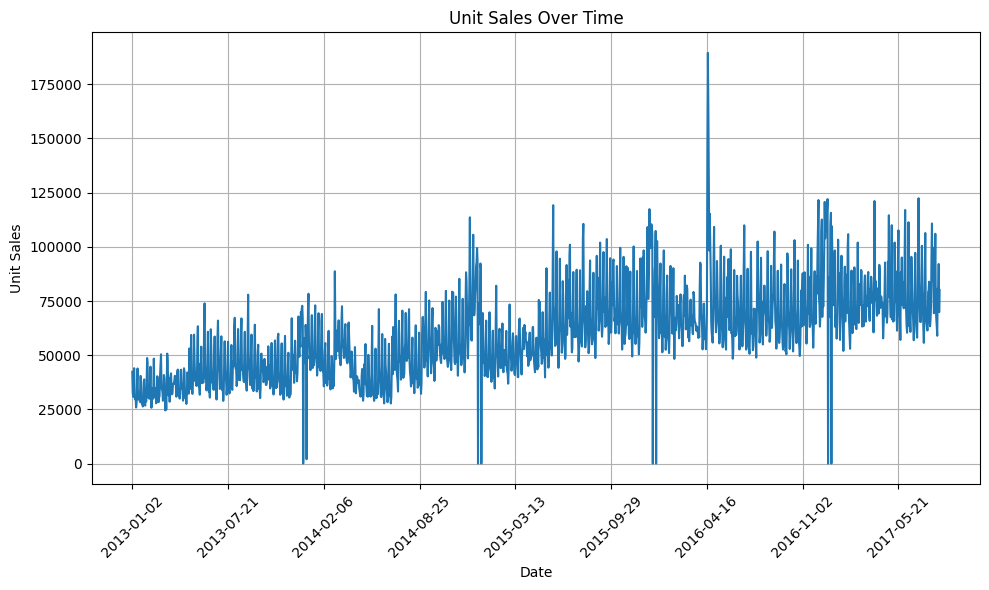

In [77]:
# Зчитування агрегованого датасету
df = pd.read_csv('data.csv')

# Перевірка перших рядків
display(df.head())

# Візуалізація
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['unit_sales'])
plt.title('Unit Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(df['date'][::200], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Попередній аналіз

Проведіть сезонну декомпозицію ряду (trend + seasonal + residual).
Опишіть основні тренди, сезонність та можливі аномалії

In [78]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('D')

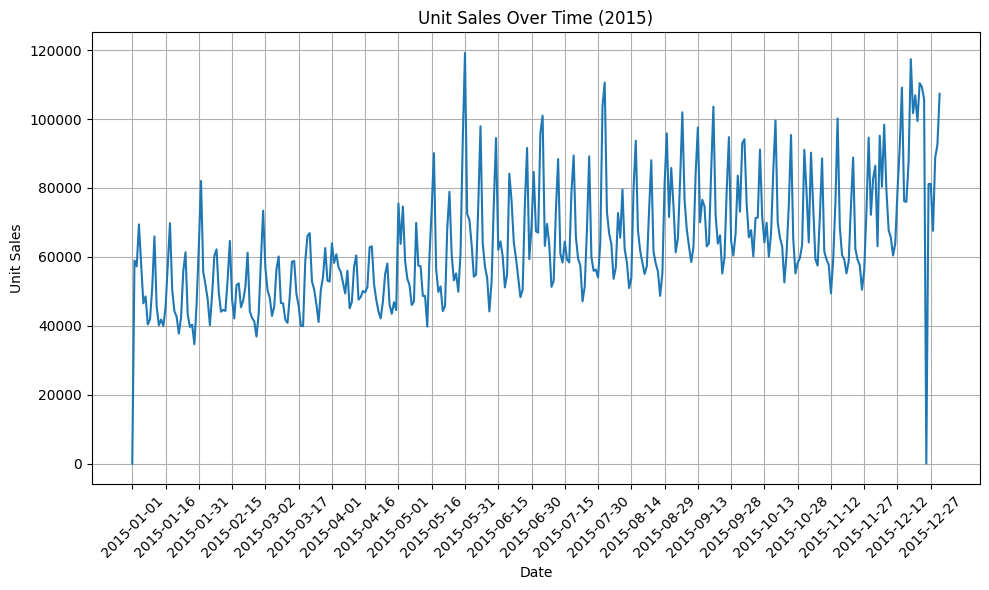

In [79]:
# Plot data for year 2015 separately
df_2015 = df.loc['2015']
plt.figure(figsize=(10, 6))
plt.plot(df_2015.index, df_2015['unit_sales'])
plt.title('Unit Sales Over Time (2015)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(df_2015.index[::15], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

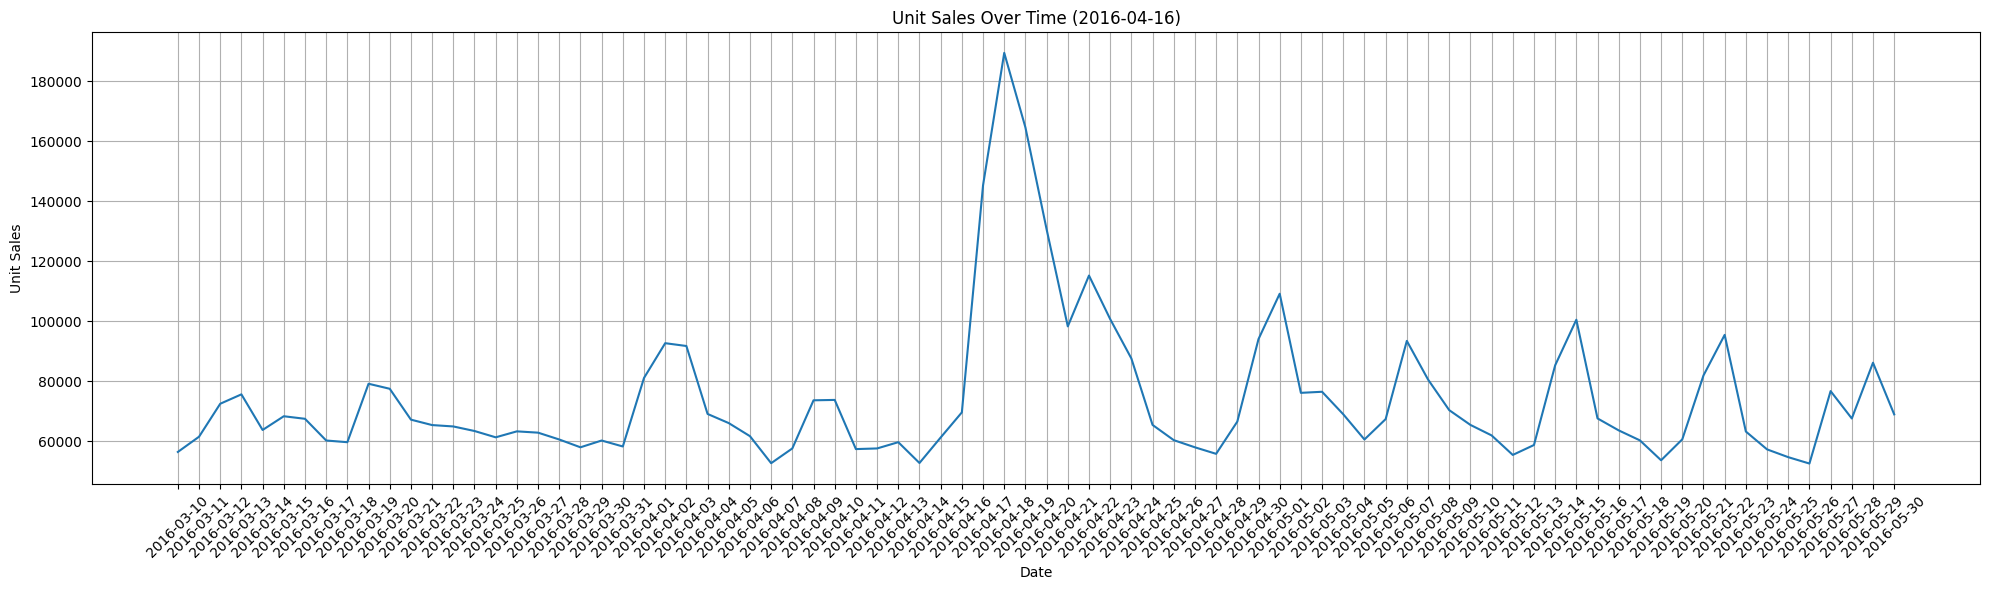

In [80]:
df_spike = df.loc['2016-03-10':'2016-05-30']
plt.figure(figsize=(20, 6))
plt.plot(df_spike.index, df_spike['unit_sales'])
plt.title('Unit Sales Over Time (2016-04-16)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(df_spike.index[::1], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

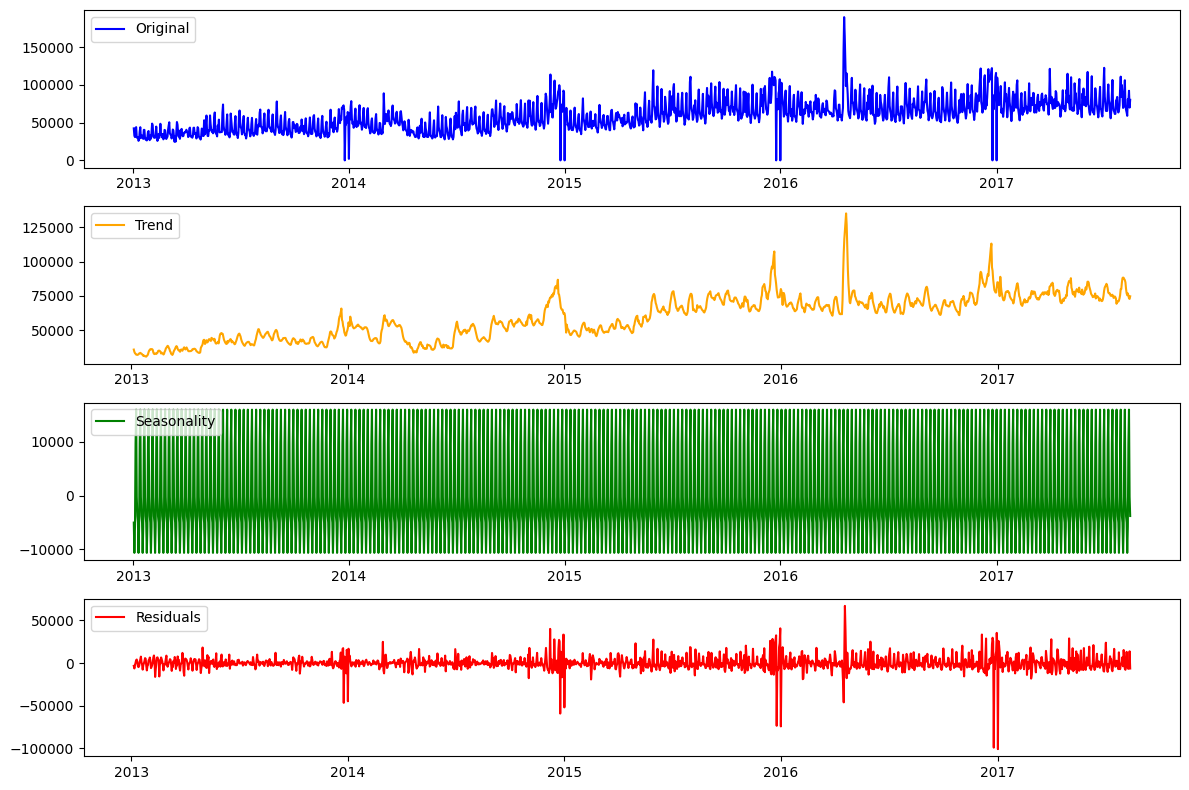

81370146.09736282


In [81]:
#Decompose the time series to trend seasonality and residuals
decomposition = seasonal_decompose(df['unit_sales'], model='additive', period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['unit_sales'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show() 

print((residual.sum())**2)


Trends: Clear yet not a sharp trend upwords with noticable boost around 2015-2016 period fading afterwards 

Seasonality: Weekly, yearly 

Anomalies: Clear drops around 01 January — which is expected pattern due to holidays and must be modelled accrodingly. Also, there is an unexpected spike 2016-04-17. As there is no info about this spike so I will replace it with appropriate technique 

In [ ]:
# Handling Anomalies (not the best technique but suffices for this case)

window_start = "2016-04-13"
window_end = "2016-04-27"

# Rolling mean of the previous 14 days (shifted so window doesn't peek ahead)
prev14_mean = df["unit_sales"].rolling(14, min_periods=1).median().shift(1)

df.loc[window_start:window_end, "unit_sales"] = prev14_mean.loc[window_start:window_end]

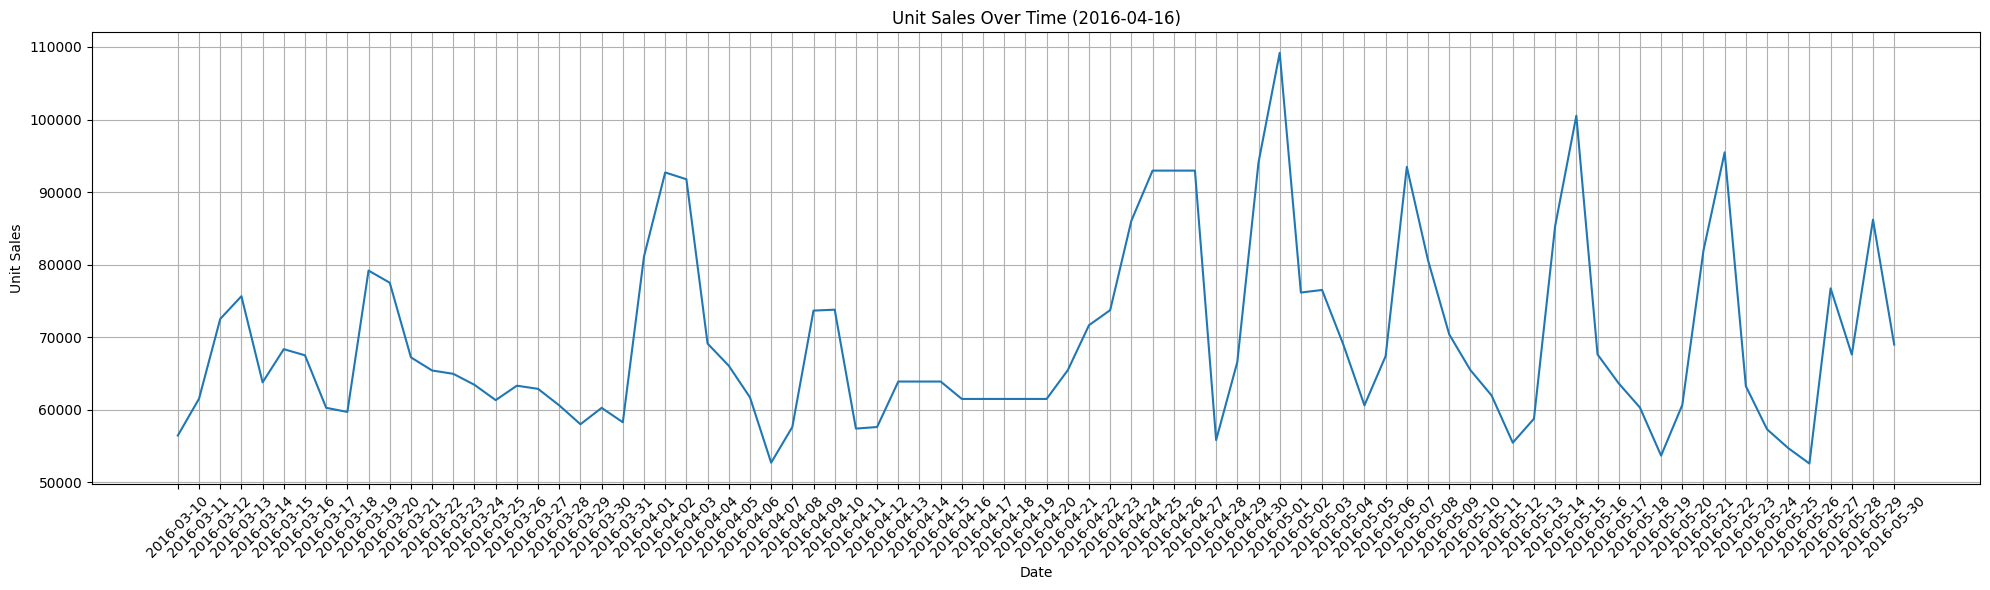

In [83]:
plt.figure(figsize=(20, 6))
plt.plot(df_spike.index, df_spike['unit_sales'])
plt.title('Unit Sales Over Time (2016-04-16)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(df_spike.index[::1], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Re the anomaly handling: Not a perfect approach but suffices for this exercise. 

Побудова моделі

Оберіть одну або кілька моделей для прогнозу (наприклад: ETS, ARIMA, Prophet).
Навчіть модель на історичних даних.

Прогнозування

Побудуйте прогноз продажів на наступні 3 місяці.
Візуалізуйте результати разом із історичними даними.

Оцінка моделі

Обчисліть метрики точності: MAE, RMSE, MAPE.
Порівняйте результати кількох моделей (якщо їх кілька).

In [84]:
df = df.rename(columns={'unit_sales': 'y'})
df = df.reset_index().rename(columns={'date': 'ds'})
df.head()

,ds,y
0,2013-01-02,42320.0
1,2013-01-03,32708.0
2,2013-01-04,30847.0
3,2013-01-05,42351.0
4,2013-01-06,43988.0


In [85]:
train, test = df[:-90], df[-90:] 

In [86]:
model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
            )
model.fit(train)

future = model.make_future_dataframe(periods=90, freq='d')

forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Filter only the forecasted period (last 12 months)
forecast_test = forecast.iloc[-len(test):]

# Extract yhat (predictions) and actual y
y_true = test['y'].values
y_pred = forecast_test['yhat'].values

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# R² score
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

16:29:42 - cmdstanpy - INFO - Chain [1] start processing
16:29:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 8705.54
R² Score: 0.6715


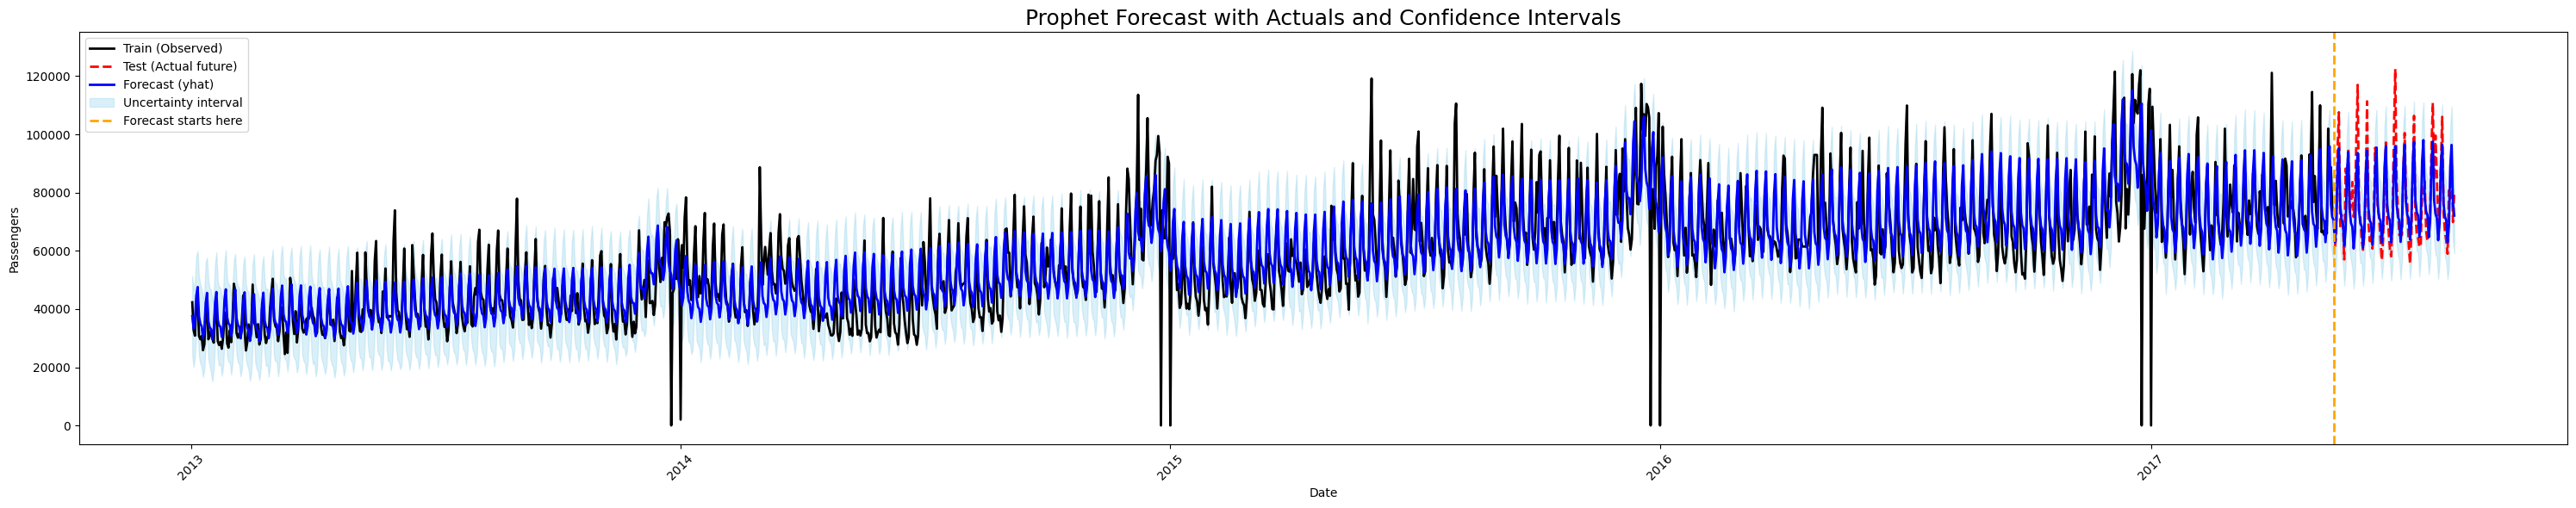

In [87]:
#@title Visualization for Prophet forecast

plt.figure(figsize=(30, 6))

# 1. Plot historical data (train)
plt.plot(train['ds'], train['y'], label='Train (Observed)', color='black', linewidth=2)

# 2. Plot actual future data (test)
plt.plot(test['ds'], test['y'], label='Test (Actual future)', color='red', linestyle='--', linewidth=2)

# 3. Plot forecasted yhat
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (yhat)', color='blue', linewidth=2)

# 4. Confidence interval shading
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='skyblue',
    alpha=0.3,
    label='Uncertainty interval'
)

# 5. Mark start of forecast
plt.axvline(
    x=train['ds'].max(),
    color='orange',
    linestyle='--',
    linewidth=2,
    label='Forecast starts here'
)

plt.title("Prophet Forecast with Actuals and Confidence Intervals", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Висновки

Опишіть, які тенденції ви виявили.
Яка модель показала найкращий результат і чому.
Які чинники могли б покращити прогноз (наприклад, додаткові фічі або зовнішні дані).